# Gradient Boosting with CatBoost

we will use dataset Amazon Employee Access Challenge from Kaggle competition for our experiments. [Here](https://www.kaggle.com/c/amazon-employee-access-challenge/data) is the link to the challenge, that we will be exploring.

### Importing Libraries

In [3]:
import os
import pandas as pd
import numpy as np
import catboost

In [4]:
np.set_printoptions(precision=4)

In [5]:
## Reading the data

from catboost.datasets import amazon

In [6]:
# If you have "URLError: SSL: CERTIFICATE_VERIFY_FAILED" uncomment next two lines:
# import ssl
# ssl._create_default_https_context = ssl._create_unverified_context

# If you have any other error:
# Download datasets from http://bit.ly/2ZUXTSv and uncomment next line:
# train_df = pd.read_csv('train.csv', sep=',', header='infer')

In [8]:
train_df, test_df = amazon()

In [9]:
train_df.head()

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325


In [12]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32769 entries, 0 to 32768
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   ACTION            32769 non-null  int64
 1   RESOURCE          32769 non-null  int64
 2   MGR_ID            32769 non-null  int64
 3   ROLE_ROLLUP_1     32769 non-null  int64
 4   ROLE_ROLLUP_2     32769 non-null  int64
 5   ROLE_DEPTNAME     32769 non-null  int64
 6   ROLE_TITLE        32769 non-null  int64
 7   ROLE_FAMILY_DESC  32769 non-null  int64
 8   ROLE_FAMILY       32769 non-null  int64
 9   ROLE_CODE         32769 non-null  int64
dtypes: int64(10)
memory usage: 2.5 MB


In [14]:
train_df.nunique()

ACTION                 2
RESOURCE            7518
MGR_ID              4243
ROLE_ROLLUP_1        128
ROLE_ROLLUP_2        177
ROLE_DEPTNAME        449
ROLE_TITLE           343
ROLE_FAMILY_DESC    2358
ROLE_FAMILY           67
ROLE_CODE            343
dtype: int64

In [18]:
### Looking on label balance in dataset
train_df['ACTION'].value_counts()

1    30872
0     1897
Name: ACTION, dtype: int64

In [11]:
### Label values extraction
X = train_df.drop('ACTION', axis=1)
y = train_df['ACTION']

In [15]:
### Categorical features declaration
cat_features = list(range(0, X.shape[1]))
print(cat_features)

[0, 1, 2, 3, 4, 5, 6, 7, 8]


In [20]:
### Training first simple catboost model
from catboost import CatBoostClassifier

model = CatBoostClassifier()
model.fit(X, y, cat_features=cat_features, verbose=100)

Learning rate set to 0.045713
0:	learn: 0.6395568	total: 45.2ms	remaining: 45.2s
100:	learn: 0.1533699	total: 8.54s	remaining: 1m 15s
200:	learn: 0.1458670	total: 19s	remaining: 1m 15s
300:	learn: 0.1420300	total: 29.3s	remaining: 1m 8s
400:	learn: 0.1382725	total: 39.9s	remaining: 59.6s
500:	learn: 0.1349133	total: 50.7s	remaining: 50.5s
600:	learn: 0.1319057	total: 1m 1s	remaining: 40.6s
700:	learn: 0.1292087	total: 1m 11s	remaining: 30.6s
800:	learn: 0.1262376	total: 1m 22s	remaining: 20.5s
900:	learn: 0.1237563	total: 1m 33s	remaining: 10.2s
999:	learn: 0.1212572	total: 1m 43s	remaining: 0us


In [21]:
### prediction on X data points
model.predict_proba(X)

array([[0.0018, 0.9982],
       [0.0079, 0.9921],
       [0.0212, 0.9788],
       ...,
       [0.0065, 0.9935],
       [0.0276, 0.9724],
       [0.0187, 0.9813]])

### Pool 

Pool class is used for storing the dataset. You can use Pool class if the dataset has more than just X and y (for example, it has sample weights or groups) or if the dataset is large and it takes long time to read it into python.


In [23]:
from catboost import Pool
from sklearn.model_selection import train_test_split

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

train_pool = Pool(
    data = X_train, 
    label = y_train, 
    cat_features = cat_features
)

validation_pool = Pool(
    data = X_test,
    label = y_test,
    cat_features = cat_features
)

### Selecting the objective function:

Possible options for binary classification:

    Logloss for binary target.
    CrossEntropy for probabilities in target.

In [25]:
model = CatBoostClassifier(
    iterations=5,
    learning_rate=0.1,
    # loss_function='CrossEntropy' # default is Logloss
)

model.fit(train_pool, eval_set=validation_pool, verbose=False)

print('Model is fitted: {}'.format(model.is_fitted()))
print('Model params:\n{}'.format(model.get_params()))

Model is fitted: True
Model params:
{'iterations': 5, 'learning_rate': 0.1}


### Stdout of the training

If verbose is not defined it will fill the O/P with stdout of each iteration.

In [28]:
model = CatBoostClassifier(
    iterations=15,
    #verbose=5,
)
model.fit(train_pool, eval_set=validation_pool);

Learning rate set to 0.441257
0:	learn: 0.4209313	test: 0.4251782	best: 0.4251782 (0)	total: 22.1ms	remaining: 310ms
1:	learn: 0.3130459	test: 0.3198648	best: 0.3198648 (1)	total: 58ms	remaining: 377ms
2:	learn: 0.2598816	test: 0.2695196	best: 0.2695196 (2)	total: 85.5ms	remaining: 342ms
3:	learn: 0.2300876	test: 0.2405125	best: 0.2405125 (3)	total: 107ms	remaining: 295ms
4:	learn: 0.2057619	test: 0.2147731	best: 0.2147731 (4)	total: 139ms	remaining: 277ms
5:	learn: 0.1925296	test: 0.2000481	best: 0.2000481 (5)	total: 174ms	remaining: 261ms
6:	learn: 0.1859953	test: 0.1938409	best: 0.1938409 (6)	total: 225ms	remaining: 257ms
7:	learn: 0.1808949	test: 0.1884482	best: 0.1884482 (7)	total: 265ms	remaining: 232ms
8:	learn: 0.1770093	test: 0.1836724	best: 0.1836724 (8)	total: 309ms	remaining: 206ms
9:	learn: 0.1737641	test: 0.1797508	best: 0.1797508 (9)	total: 337ms	remaining: 169ms
10:	learn: 0.1731531	test: 0.1797895	best: 0.1797508 (9)	total: 364ms	remaining: 132ms
11:	learn: 0.1727161	t

### Metrics calculation and graph plotting

In [29]:
model = CatBoostClassifier(
    iterations=50,
    learning_rate=0.5,
    custom_loss=['AUC', 'Accuracy']
)

model.fit(
    train_pool,
    eval_set=validation_pool,
    verbose=False,
    plot=True
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

### Model comparison

In [32]:
from catboost import MetricVisualizer

In [30]:
model1 = CatBoostClassifier(
    learning_rate=0.7,
    iterations=100,
    train_dir='learing_rate_0.7'
)

model2 = CatBoostClassifier(
    learning_rate=0.01,
    iterations=100,
    train_dir='learing_rate_0.01'
)

model1.fit(train_pool, eval_set=validation_pool, verbose=False)
model2.fit(train_pool, eval_set=validation_pool, verbose=False)

In [33]:
MetricVisualizer(['learing_rate_0.7', 'learing_rate_0.01']).start()

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

### Best iteration

In [49]:
model = CatBoostClassifier(
    iterations=200,
#    use_best_model=False
)

model.fit(
    train_pool,
    eval_set=validation_pool,
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [50]:
print('Tree count: ' + str(model.tree_count_))

Tree count: 187


### Cross-validation

In [51]:
from catboost import cv

In [52]:
params = {
    'loss_function': 'Logloss',
    'iterations': 80,
    'custom_loss': 'AUC',
    'learning_rate': 0.5,
}

**Non stratified**

In [53]:
cv_data = cv(
    params = params,
    pool = train_pool,
    fold_count=5,
    shuffle=True,
    partition_random_seed=32,
    plot=True,
    verbose=False
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.1566298641
bestIteration = 22

Training on fold [1/5]

bestTest = 0.1662047348
bestIteration = 31

Training on fold [2/5]

bestTest = 0.1569414511
bestIteration = 46

Training on fold [3/5]

bestTest = 0.1618021561
bestIteration = 30

Training on fold [4/5]

bestTest = 0.1671706304
bestIteration = 14



In [54]:
cv_data.head(10)

,iterations,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std,test-AUC-mean,test-AUC-std
0,0,0.300392,0.001660,0.300370,0.001694,0.487877,0.005842
1,1,0.227480,0.004729,0.228986,0.003496,0.604238,0.057093
2,2,0.190768,0.001869,0.197501,0.001366,0.759654,0.028037
3,3,0.178391,0.002710,0.185944,0.000822,0.795903,0.022081
4,4,0.173058,0.003133,0.180950,0.001339,0.808126,0.019280
5,5,0.169896,0.003995,0.177944,0.001305,0.820367,0.016668
6,6,0.167679,0.003824,0.175530,0.000716,0.830642,0.010800
7,7,0.166516,0.003928,0.173947,0.000576,0.833412,0.009532
8,8,0.165369,0.003787,0.172408,0.000428,0.836627,0.010023
9,9,0.164642,0.003739,0.171468,0.000606,0.838087,0.008911


In [56]:
best_value = np.min(cv_data['test-Logloss-mean'])
best_iter = np.argmin(cv_data['test-Logloss-mean'])

print('Best validation Logloss score, non stratified: {:.4f}±{:.4f} on step {}'.format(
    best_value,
    cv_data['test-Logloss-std'][best_iter],
    best_iter)
)

Best validation Logloss score, non stratified: 0.1626±0.0052 on step 25


**Stratified**

In [57]:
cv_data = cv(
    params = params,
    pool = train_pool,
    fold_count=5,
    shuffle=True,
    partition_random_seed=32,
    plot=True,
    stratified=False,
    verbose=False
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.1563838471
bestIteration = 24

Training on fold [1/5]

bestTest = 0.1733682387
bestIteration = 31

Training on fold [2/5]

bestTest = 0.1561868359
bestIteration = 41

Training on fold [3/5]

bestTest = 0.1505708512
bestIteration = 50

Training on fold [4/5]

bestTest = 0.169566106
bestIteration = 44



In [58]:
best_value = cv_data['test-Logloss-mean'].min()
best_iter = cv_data['test-Logloss-mean'].values.argmin()

print('Best validation Logloss score, stratified: {:.4f}±{:.4f} on step {}'.format(
    best_value,
    cv_data['test-Logloss-std'][best_iter],
    best_iter)
)

Best validation Logloss score, stratified: 0.1622±0.0096 on step 30


### Overfitting Detector

In [59]:
model_with_early_stop = CatBoostClassifier(
    iterations=200,
    learning_rate=0.5,
    early_stopping_rounds=20
)

model_with_early_stop.fit(
    train_pool,
    eval_set=validation_pool,
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [60]:
print(model_with_early_stop.tree_count_)

41


**Overfitting Detector with eval metric**

In [61]:
model_with_early_stop = CatBoostClassifier(
    eval_metric='AUC',
    iterations=200,
    learning_rate=0.5,
    early_stopping_rounds=20
)
model_with_early_stop.fit(
    train_pool,
    eval_set=validation_pool,
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [62]:
print(model_with_early_stop.tree_count_)

41


### Hyperparameter tuning

In [63]:
from sklearn.model_selection import GridSearchCV

In [64]:
param_grid = {
    "learning_rate": [0.001, 0.01, 0.5],
}

clf = CatBoostClassifier(
    iterations=20, 
    cat_features=cat_features, 
    verbose=20
)

In [65]:
grid_search = GridSearchCV(clf, param_grid=param_grid, cv=5)

results = grid_search.fit(X_train, y_train)

0:	learn: 0.6923611	total: 30.2ms	remaining: 574ms
19:	learn: 0.6777406	total: 761ms	remaining: 0us
0:	learn: 0.6923613	total: 22.9ms	remaining: 435ms
19:	learn: 0.6777461	total: 704ms	remaining: 0us
0:	learn: 0.6923616	total: 21.9ms	remaining: 415ms
19:	learn: 0.6777497	total: 819ms	remaining: 0us
0:	learn: 0.6923612	total: 31.8ms	remaining: 605ms
19:	learn: 0.6777483	total: 720ms	remaining: 0us
0:	learn: 0.6923615	total: 30.8ms	remaining: 586ms
19:	learn: 0.6777483	total: 678ms	remaining: 0us
0:	learn: 0.6853219	total: 35ms	remaining: 665ms
19:	learn: 0.5620841	total: 768ms	remaining: 0us
0:	learn: 0.6853235	total: 19.1ms	remaining: 363ms
19:	learn: 0.5621273	total: 760ms	remaining: 0us
0:	learn: 0.6853268	total: 23.3ms	remaining: 443ms
19:	learn: 0.5621562	total: 833ms	remaining: 0us
0:	learn: 0.6853227	total: 25.4ms	remaining: 483ms
19:	learn: 0.5621473	total: 660ms	remaining: 0us
0:	learn: 0.6853258	total: 55.1ms	remaining: 1.05s
19:	learn: 0.5621545	total: 805ms	remaining: 0us
0:

In [66]:
results.best_estimator_.get_params()

{'iterations': 20,
 'learning_rate': 0.5,
 'verbose': 20,
 'cat_features': [0, 1, 2, 3, 4, 5, 6, 7, 8]}

### Model predictions

In [67]:
model = CatBoostClassifier(iterations=200, learning_rate=0.03)
model.fit(train_pool, verbose=50);

0:	learn: 0.6568584	total: 38.3ms	remaining: 7.62s
50:	learn: 0.1925870	total: 2.86s	remaining: 8.37s
100:	learn: 0.1623657	total: 6.13s	remaining: 6.01s
150:	learn: 0.1562104	total: 9.52s	remaining: 3.09s
199:	learn: 0.1522910	total: 13.1s	remaining: 0us


In [69]:
print(model.predict(X_test))

[1 1 1 ... 1 1 1]


In [70]:
print(model.predict_proba(X_test))

[[0.0144 0.9856]
 [0.0074 0.9926]
 [0.0289 0.9711]
 ...
 [0.0348 0.9652]
 [0.0471 0.9529]
 [0.3269 0.6731]]


In [71]:
raw_pred = model.predict(
    X_test,
    prediction_type='RawFormulaVal'
)

print(raw_pred)

[4.2261 4.8966 3.5134 ... 3.3241 3.0072 0.7222]


In [72]:
from numpy import exp

sigmoid = lambda x: 1 / (1 + exp(-x))

probabilities = sigmoid(raw_pred)

print(probabilities)

[0.9856 0.9926 0.9711 ... 0.9652 0.9529 0.6731]


In [73]:
import matplotlib.pyplot as plt
from catboost.utils import get_roc_curve
from catboost.utils import get_fpr_curve
from catboost.utils import get_fnr_curve

curve = get_roc_curve(model, validation_pool)
(fpr, tpr, thresholds) = curve

(thresholds, fpr) = get_fpr_curve(curve=curve)
(thresholds, fnr) = get_fnr_curve(curve=curve)

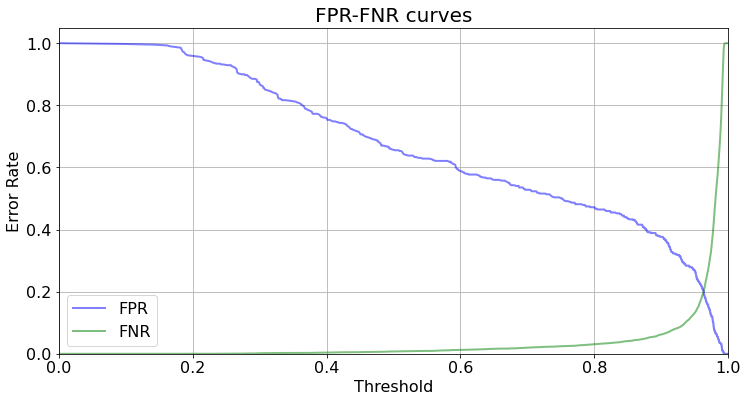

In [76]:
plt.figure(figsize=(12, 6))
style = {'alpha':0.5, 'lw':2}

plt.plot(thresholds, fpr, color='blue', label='FPR', **style)
plt.plot(thresholds, fnr, color='green', label='FNR', **style)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('Threshold', fontsize=16)
plt.ylabel('Error Rate', fontsize=16)
plt.title('FPR-FNR curves', fontsize=20)
plt.legend(loc="lower left", fontsize=16);

In [77]:
from catboost.utils import select_threshold

print(select_threshold(model, validation_pool, FNR=0.01))
print(select_threshold(model, validation_pool, FPR=0.01))

0.5644728090717929
0.9913212132694214


In [78]:
metrics = model.eval_metrics(
    data=validation_pool,
    metrics=['Logloss','AUC'],
    ntree_start=0,
    ntree_end=0,
    eval_period=1,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [79]:
print('AUC values:\n{}'.format(np.array(metrics['AUC'])))


AUC values:
[0.5248 0.627  0.6406 0.6406 0.6415 0.6411 0.6411 0.6405 0.6405 0.6456
 0.6456 0.6443 0.6498 0.6498 0.649  0.6531 0.6491 0.6554 0.6592 0.6897
 0.6897 0.6962 0.6962 0.6962 0.7167 0.7215 0.7344 0.7387 0.74   0.755
 0.755  0.7702 0.786  0.8015 0.8073 0.8169 0.8191 0.8224 0.8253 0.8293
 0.8297 0.8299 0.8322 0.8323 0.8321 0.8327 0.8338 0.8334 0.8335 0.8333
 0.8333 0.8337 0.8343 0.8342 0.8355 0.8364 0.8368 0.837  0.8377 0.8378
 0.8383 0.8385 0.8395 0.8405 0.841  0.8411 0.8411 0.8412 0.8415 0.8414
 0.8414 0.8444 0.8464 0.8482 0.8495 0.8507 0.8509 0.8517 0.8528 0.8533
 0.8538 0.8559 0.8574 0.86   0.8619 0.8634 0.8646 0.8655 0.8668 0.8678
 0.8686 0.8694 0.8699 0.8697 0.8697 0.87   0.8704 0.871  0.8715 0.8717
 0.872  0.8722 0.8724 0.8728 0.8728 0.8731 0.8735 0.8735 0.8738 0.8739
 0.8737 0.8739 0.874  0.874  0.8741 0.8741 0.874  0.8741 0.8742 0.8744
 0.8747 0.8749 0.875  0.8751 0.8753 0.8755 0.8759 0.876  0.8761 0.8761
 0.8761 0.8762 0.8763 0.8767 0.8766 0.8767 0.8766 0.8766 0.8767 0.

### Feature importances

**Prediction values change:**
- Default feature importances for binary classification is PredictionValueChange - how much on average does the model change when the feature value changes. 
- These feature importances are non negative. 
- They are normalized and sum to 1, so you can look on these values like percentage of importance.

In [80]:
np.array(model.get_feature_importance(prettified=True))

array([['RESOURCE', 24.653154441209242],
       ['ROLE_DEPTNAME', 16.894406008166353],
       ['MGR_ID', 16.072067437188117],
       ['ROLE_CODE', 12.00013083695185],
       ['ROLE_ROLLUP_2', 7.727095864480384],
       ['ROLE_FAMILY_DESC', 6.8563077663271725],
       ['ROLE_FAMILY', 6.590343495508479],
       ['ROLE_TITLE', 4.635369035826631],
       ['ROLE_ROLLUP_1', 4.571125114341639]], dtype=object)

**Loss function change:**
- The non default feature importance approximates how much the optimized loss function will change if the value of the feature changes. 
- This importances might be negative if the feature has bad influence on the loss function. 
- The importances are not normalized, the absolute value of the importance has the same scale as the optimized loss value. 
- To calculate this importance value you need to pass train_pool as an argument.

In [81]:
np.array(model.get_feature_importance(
    data=train_pool, 
    type='LossFunctionChange', 
    prettified=True
))

array([['RESOURCE', 0.021776267716979145],
       ['MGR_ID', 0.018649199037281662],
       ['ROLE_DEPTNAME', 0.013826477716664919],
       ['ROLE_CODE', 0.012269276883838946],
       ['ROLE_FAMILY_DESC', 0.007470422555927919],
       ['ROLE_ROLLUP_2', 0.002531278817883881],
       ['ROLE_ROLLUP_1', 0.0011389634756994473],
       ['ROLE_TITLE', 0.0006149941424949216],
       ['ROLE_FAMILY', 0.00036779895360601844]], dtype=object)